In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Datasets/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

<AxesSubplot:>

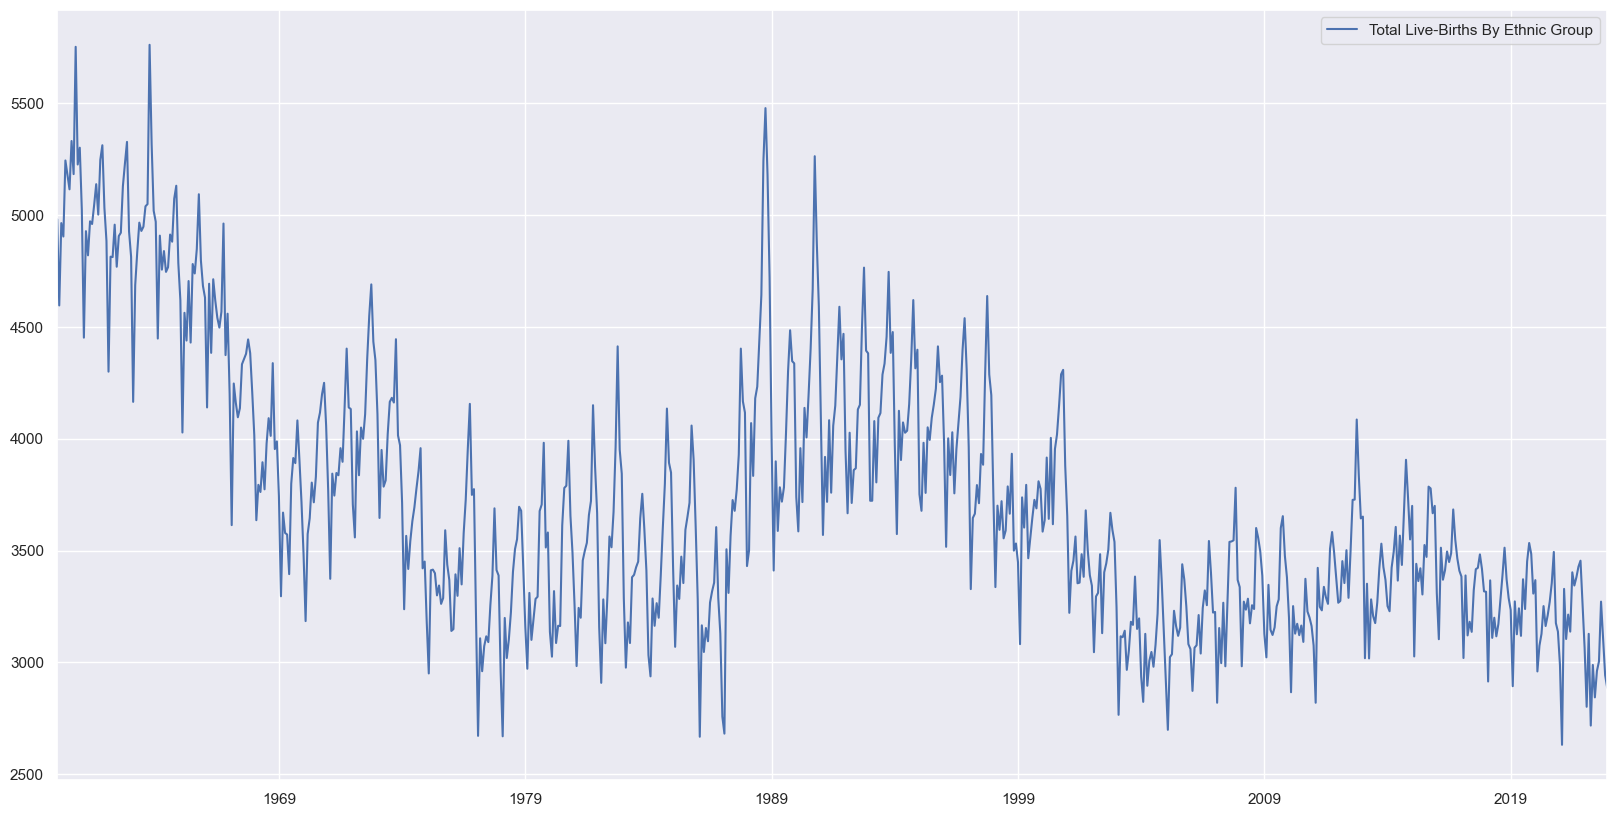

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

## Variable: Food Cost

- Standardized the date to `YYYY-MM` following the date format for the birth count dataset

In [5]:
# Variable: Food Costs
food = pd.read_csv('Datasets/FnB_Services_Index.csv', header = 0)
food = food.rename(columns = {'Data Series':'Date','Fast Food Outlets':'Fast Food','Cafes, Food Courts & Other Eating Places':'Others'})
birthData = birthData.rename(columns=lambda x: x.strip())
food['Date'] = pd.to_datetime(food['Date'])
food['Date'] = food['Date'].dt.strftime('%Y-%m')

food = food.set_index('Date')
food.index = pd.to_datetime(food.index).to_period('M')
food = food.fillna(0)

<AxesSubplot:>

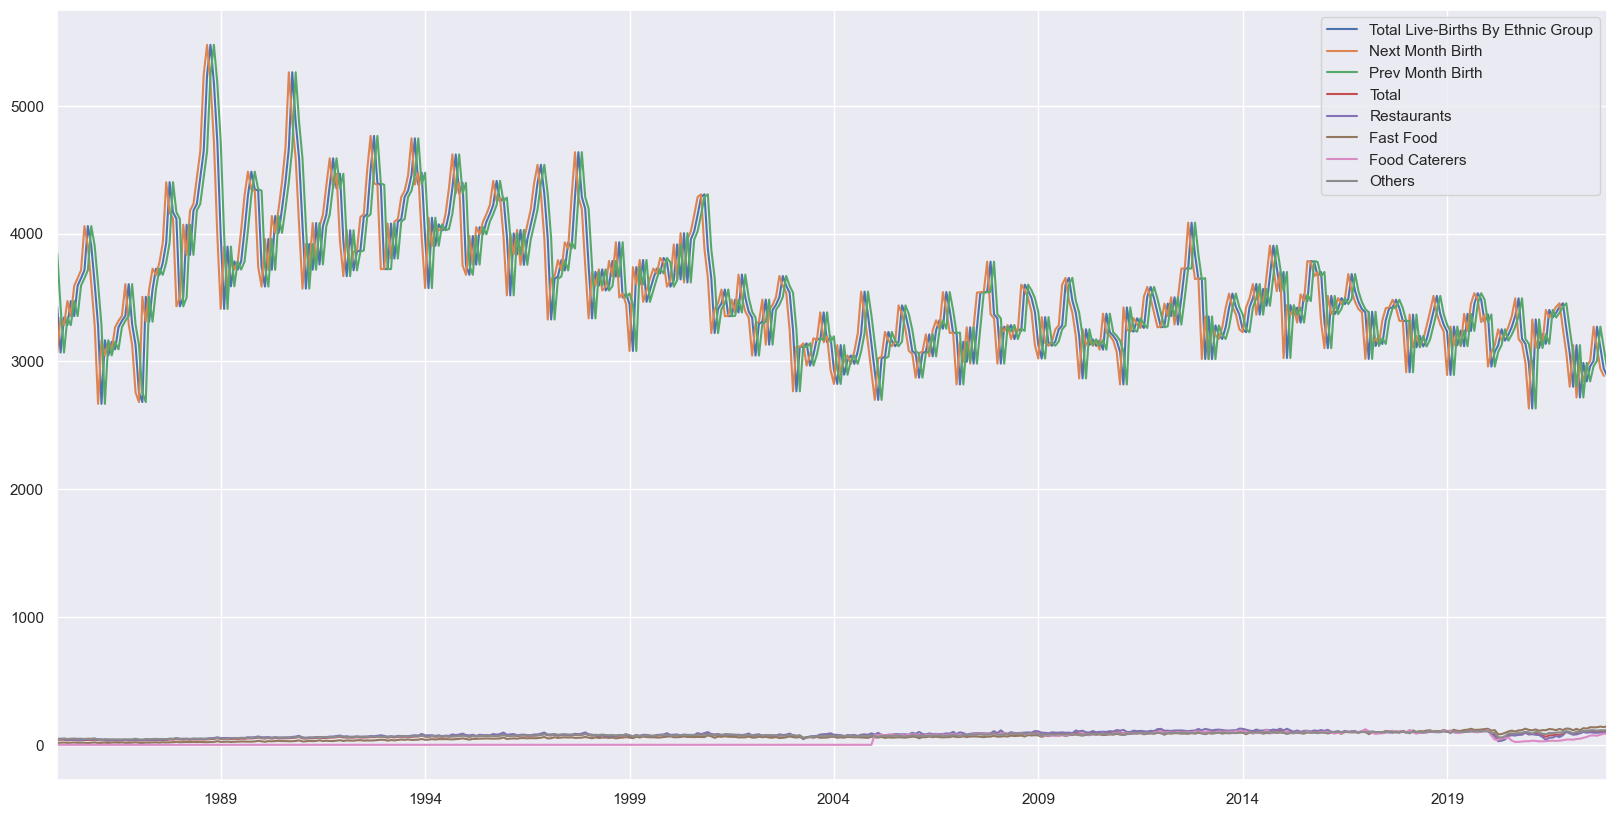

In [6]:
foodBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
foodBaby['Next Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(-1)
foodBaby['Prev Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(1)
foodTotal = foodBaby.join(food['Total'], how='inner')
foodRestaurant = foodBaby.join(food['Restaurants'], how='inner')
foodFastFood = foodBaby.join(food['Fast Food'], how='inner')
foodFoodCaterers = foodBaby.join(food['Food Caterers'], how='inner')
foodOthers = foodBaby.join(food['Others'], how='inner')
foodMerge = pd.concat([foodTotal, foodRestaurant, foodFastFood, foodFoodCaterers, foodOthers], axis=1, join='inner')
foodMerge = foodMerge.loc[:,~foodMerge.columns.duplicated(keep='first')]
foodMerge.plot(figsize=(20, 10))

In [7]:
foodMerge.info()
foodMerge.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 456 entries, 1985-01 to 2022-12
Freq: M
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  456 non-null    int64  
 1   Next Month Birth                   455 non-null    float64
 2   Prev Month Birth                   456 non-null    float64
 3   Total                              456 non-null    float64
 4   Restaurants                        456 non-null    float64
 5   Fast Food                          456 non-null    float64
 6   Food Caterers                      456 non-null    float64
 7   Others                             456 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 48.2 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,Total,Restaurants,Fast Food,Food Caterers,Others
Total Live-Births By Ethnic Group,1.000000,0.857176,0.856346,-0.356590,-0.291417,-0.476055,-0.468371,-0.349138
Next Month Birth,0.857176,1.000000,0.773787,-0.394874,-0.325221,-0.499510,-0.464986,-0.396923
Prev Month Birth,0.856346,0.773787,1.000000,-0.351712,-0.264588,-0.479969,-0.468552,-0.370455
Total,-0.356590,-0.394874,-0.351712,1.000000,0.954302,0.892406,0.801143,0.959811
Restaurants,-0.291417,-0.325221,-0.264588,0.954302,1.000000,0.741979,0.789390,0.842561
Fast Food,-0.476055,-0.499510,-0.479969,0.892406,0.741979,1.000000,0.723844,0.949052
Food Caterers,-0.468371,-0.464986,-0.468552,0.801143,0.789390,0.723844,1.000000,0.733458
Others,-0.349138,-0.396923,-0.370455,0.959811,0.842561,0.949052,0.733458,1.000000


## Analysis
- `Restaurants` does not have a good enough correlation with Total Live-Births By Ethnic Group, thus removed
- `Food Caterers` does not have sufficient data points as it is only available from 2005 onwards, thus removed

In [8]:
foodUpdate = pd.concat([foodTotal, foodFastFood, foodOthers], axis=1, join='inner')
foodUpdate = foodUpdate.loc[:,~foodUpdate.columns.duplicated(keep='first')]
foodUpdate.info()
foodUpdate.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 456 entries, 1985-01 to 2022-12
Freq: M
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  456 non-null    int64  
 1   Next Month Birth                   455 non-null    float64
 2   Prev Month Birth                   456 non-null    float64
 3   Total                              456 non-null    float64
 4   Fast Food                          456 non-null    float64
 5   Others                             456 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 41.1 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,Total,Fast Food,Others
Total Live-Births By Ethnic Group,1.000000,0.857176,0.856346,-0.356590,-0.476055,-0.349138
Next Month Birth,0.857176,1.000000,0.773787,-0.394874,-0.499510,-0.396923
Prev Month Birth,0.856346,0.773787,1.000000,-0.351712,-0.479969,-0.370455
Total,-0.356590,-0.394874,-0.351712,1.000000,0.892406,0.959811
Fast Food,-0.476055,-0.499510,-0.479969,0.892406,1.000000,0.949052
Others,-0.349138,-0.396923,-0.370455,0.959811,0.949052,1.000000


## Classification: Random Forest
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - Total/Fast Food/Others

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [9]:
results = []

for i in range(250):
    seed = random.randint(0, 10000)
    # Step 1: Create binary target variable
    foodUpdate['Rise-Fall'] = (foodUpdate['Total Live-Births By Ethnic Group'] > foodUpdate['Next Month Birth']).astype(int)

    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Total', 'Fast Food','Others']]

    # Step 2.2: Response
    y = foodUpdate['Rise-Fall']

    # Step 3: Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Step 4: Create Random Forest Classifier object
    rf = RandomForestClassifier(n_estimators=100, max_depth=5)

    # Step 5: Fit model to training data
    rf.fit(X_train, y_train)

    # Step 6: Make predictions on test data
    y_pred = rf.predict(X_test)

    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confuse = confusion_matrix(y_test, y_pred)

    results.append((seed, accuracy, precision, recall, f1, confuse))


# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [10]:
results = results[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {results[i][0]}:")
    print(f'Accuracy  = {results[i][1]:.4f}')
    print(f'Precision = {results[i][2]:.4f}')
    print(f'Recall    = {results[i][3]:.4f}')
    print(f'F1 score  = {results[i][4]:.4f}')

print('----------------------------------------------')

----------------------------------------------
Random state 1541:
Accuracy  = 0.7826
Precision = 0.7308
Recall    = 0.8636
F1 score  = 0.7917
----------------------------------------------
Random state 8817:
Accuracy  = 0.7500
Precision = 0.7692
Recall    = 0.7843
F1 score  = 0.7767
----------------------------------------------
Random state 6122:
Accuracy  = 0.7609
Precision = 0.7551
Recall    = 0.7872
F1 score  = 0.7708
----------------------------------------------
Random state 2533:
Accuracy  = 0.7391
Precision = 0.6667
Recall    = 0.8837
F1 score  = 0.7600
----------------------------------------------
Random state 9185:
Accuracy  = 0.7500
Precision = 0.7447
Recall    = 0.7609
F1 score  = 0.7527
----------------------------------------------


In [11]:
print(f'Average Accuracy:  {sum([i[1] for i in results])/5:.4f}')
print(f'Average Precision: {sum([i[2] for i in results])/5:.4f}')
print(f'Average Recall:    {sum([i[3] for i in results])/5:.4f}')
print(f'Average F1 Score:  {sum([i[4] for i in results])/5:.4f}')

Average Accuracy:  0.7565
Average Precision: 0.7333
Average Recall:    0.8160
Average F1 Score:  0.7704


## Final Verdict for Food Costs
The average metrics from the top 5 random seeds are mostly more than 0.75 till even 0.8

Pretty descent model as shown in predicting next month birth count